Time Series Forecasting Assignment 2
<br>
Name: Vera (Shuyao) Fan
<br>
Andrew ID: shuyaof

In [1]:
from google.colab import drive
import os
from google.colab import files

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/Time_Series_example')
! pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/Time_Series_example


In [6]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.6 MB/s eta 0:00:00


In [7]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics
from random import gauss #create gaussian white noise
from random import seed
from pandas import Series
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity
from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
import pmdarima as pm #auto arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')


## 1. Problem Definition
Predict and back test 4 monthly periods for anti-diabetic drug sales in Australia for July 2004-June 2005, July 2005-June 2006,  July 2006-June 2007, July 2007-June 2008

https://drive.google.com/drive/folders/1xBjjQLq2IvvXZ63RkyFkQkIeiJYrCJHQ?usp=share_link


## 2. Exploratory Data Analysis

In [9]:
# Read in drug sales data
drug_sales_df = pd.read_csv('drug_sales_australia.csv',
                          parse_dates=['date'],
                         index_col=['date'])
drug_sales_df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


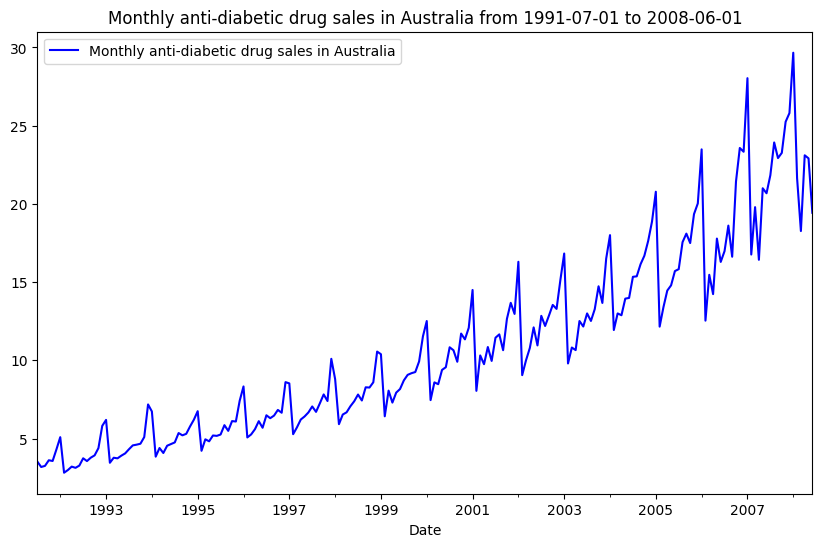

In [10]:
# set the plot size
plt.figure(figsize=(10, 6), dpi=100) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')

# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

My observation is the plot of Australian drug sales shows upward multiplicative trend with seasonality.

### 2. Check stationarity and differencing

The data is not stationary from previous plot, because it has both trend and seasonality.

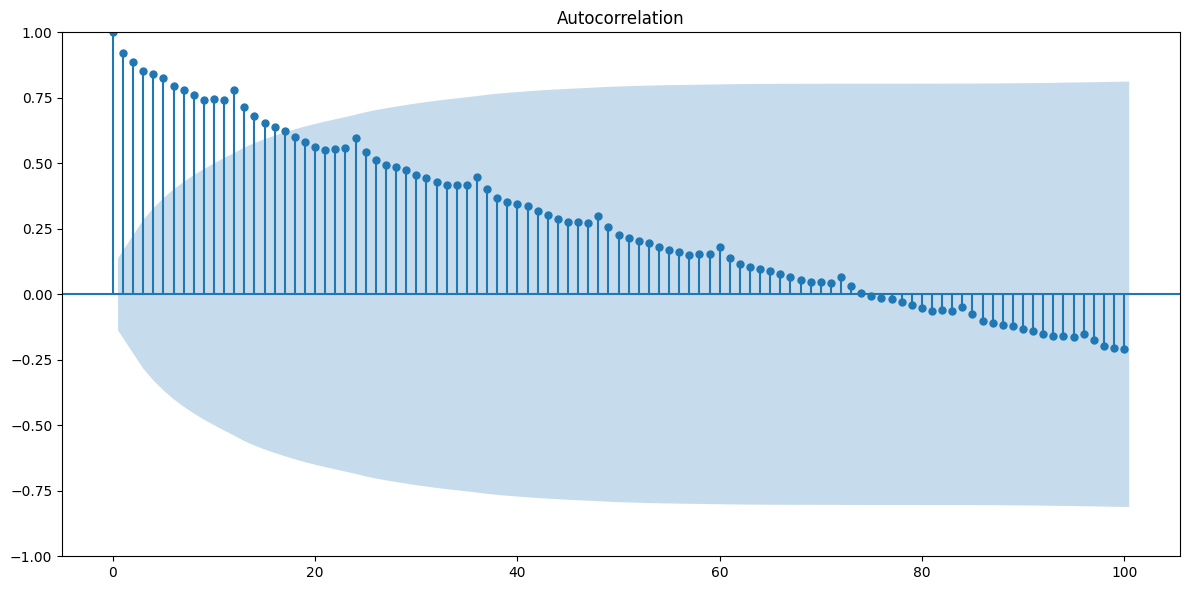

In [11]:
# autocorrelation plot of the dataset
fig = plot_acf(drug_sales_df, lags=100)
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [12]:
# Check ADF score for original dataset
X = drug_sales_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


According to the ADF score which is larger than critical value and p-value which is more than 0.05, we failed to reject the null hypothesis. Therefore, this dataset is non-stationary.

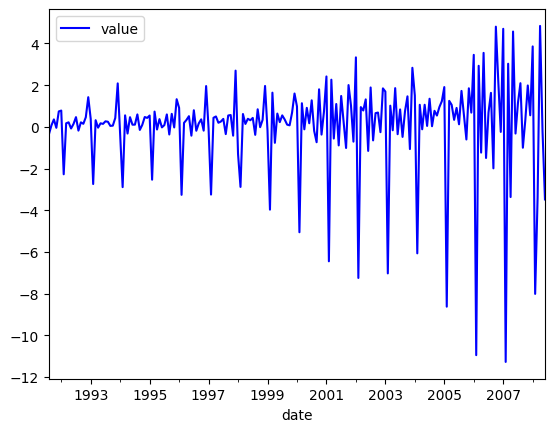

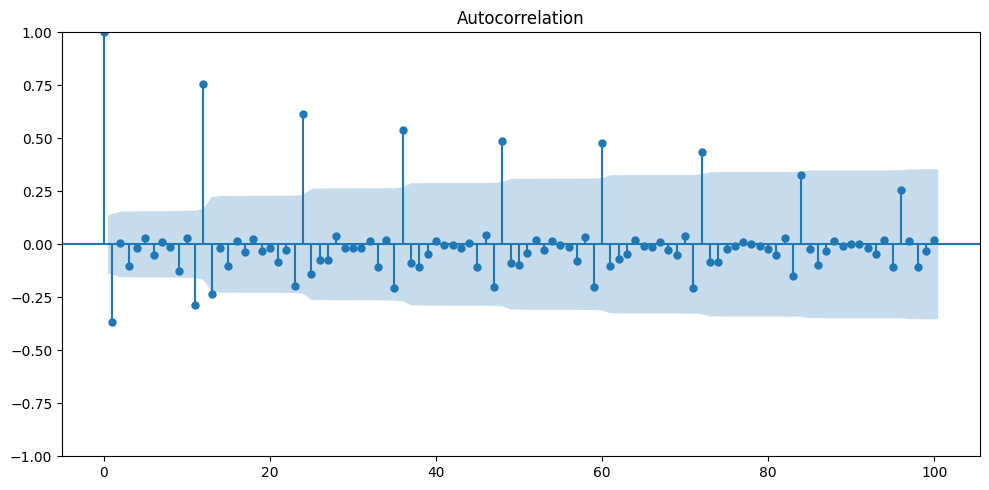

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [13]:
# Differencing the data for the 1st time
first_diff_df = drug_sales_df.diff().dropna()
first_diff_df.plot(color='blue')

# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

With the line plot, Autocorrelation plot and ADF Statistics, the dataset is still not stationary after 1st time differencing.
From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing.

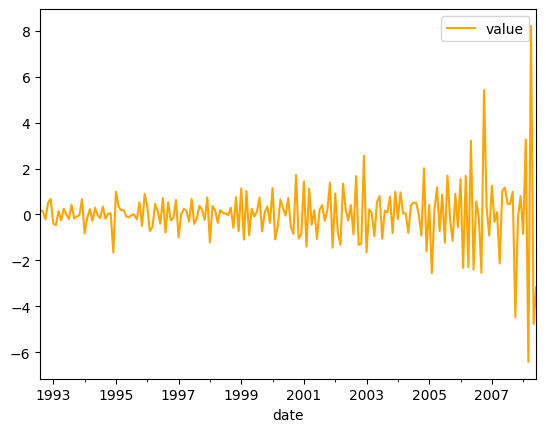

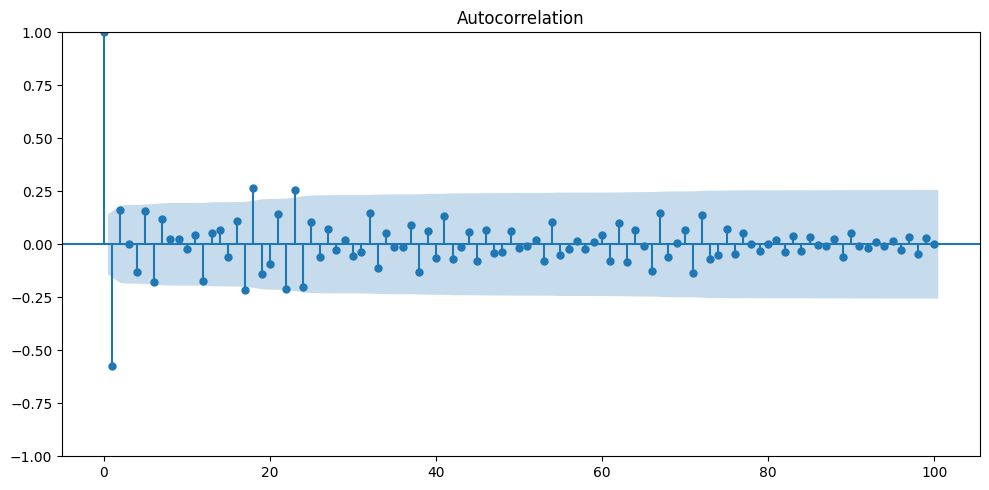

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [14]:
# Differencing for a second time
seasonal_diff_df = first_diff_df.diff(12).dropna()
seasonal_diff_df.plot(color = 'orange')

# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Since p value is less than 0.05, we can reject the null hypothesis. Therefore, the data is stationary.

## 3. Fitting models by different periods

### 3.1 Period: July 2004 - June 2005

In [15]:
train_data_1 = drug_sales_df['1991-07-01':'2004-06-01']
test_data_1 = drug_sales_df['2004-07-01':'2005-06-01']

In [16]:
# ETS Models

# Simple Exponential Smoothing
ins1 = SimpleExpSmoothing(train_data_1).fit()
ins_cast1 = ins1.forecast(12).rename('alpha=%s'%ins1.model.params['smoothing_level'])

# Double Exponential Smoothing
double_ets_add1 = ExponentialSmoothing(train_data_1, trend = 'add').fit()
double_ets_mul1 = ExponentialSmoothing(train_data_1, trend = 'mul').fit()
double_ets_add_pred1 = double_ets_add1.forecast(12)
double_ets_mul_pred1 = double_ets_mul1.forecast(12)

# Triple Exponential Smoothing
triple_ets_add1 = ExponentialSmoothing(train_data_1, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul1 = ExponentialSmoothing(train_data_1, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred1 = triple_ets_add1.forecast(12)
triple_ets_mul_pred1 = triple_ets_mul1.forecast(12)

In [17]:
# Non-Seasonal Auto ARIMA Model
non_seasonal_auto_model1 = pm.auto_arima(train_data_1, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

fc_auto_nonseasonal1, confint1 = non_seasonal_auto_model1.predict(n_periods=12, return_conf_int=True)
fc_series_auto_nonseasonal1 = pd.Series(fc_auto_nonseasonal1, index=test_data_1.index)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.692, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=598.075, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=961.453, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=565.571, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=558.166, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=560.084, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=566.735, Time=0.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=558.602, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=578.498, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=558.613, Time=0.65 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 4.620 seconds


In [18]:
# Seasonal Auto ARIMA Model
seasonal_auto_model1 = pm.auto_arima(train_data_1, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

fc_auto_seasonal1, confint1 = seasonal_auto_model1.predict(n_periods=12, return_conf_int=True)
fc_series_auto_seasonal1 = pd.Series(fc_auto_seasonal1, index=test_data_1.index)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=310.796, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=260.993, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=227.309, Time=0.23 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=229.668, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=225.508, Time=0.65 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=228.659, Time=0.26 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=225.817, Time=1.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=226.347, Time=1.60 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=224.365, Time=0.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=224.161, Time=0.86 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=225.964, Time=1.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=225.121, Time=0.56 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=306.412, Time=0.52 sec
 ARIMA(0,1,2)(0,1,2)[12]         

### 3.2 Period: July 2005 - June 2006

In [19]:
train_data_2 = drug_sales_df['1991-07-01':'2005-06-01']
test_data_2 = drug_sales_df['2005-07-01':'2006-06-01']

In [20]:
# ETS Models

# Simple Exponential Smoothing
ins2 = SimpleExpSmoothing(train_data_2).fit()
ins_cast2 = ins2.forecast(12).rename('alpha=%s'%ins2.model.params['smoothing_level'])

# Double Exponential Smoothing
double_ets_add2 = ExponentialSmoothing(train_data_2, trend = 'add').fit()
double_ets_mul2 = ExponentialSmoothing(train_data_2, trend = 'mul').fit()
double_ets_add_pred2 = double_ets_add2.forecast(12)
double_ets_mul_pred2 = double_ets_mul2.forecast(12)

# Triple Exponential Smoothing
triple_ets_add2 = ExponentialSmoothing(train_data_2, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul2 = ExponentialSmoothing(train_data_2, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred2 = triple_ets_add2.forecast(12)
triple_ets_mul_pred2 = triple_ets_mul2.forecast(12)

In [21]:
# Non-Seasonal Auto ARIMA Model
non_seasonal_auto_model2 = pm.auto_arima(train_data_2, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

fc_auto_nonseasonal2, confint2 = non_seasonal_auto_model2.predict(n_periods=12, return_conf_int=True)
fc_series_auto_nonseasonal2 = pd.Series(fc_auto_nonseasonal2, index=test_data_2.index)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1235.924, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=663.903, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1060.107, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=633.748, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=624.012, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=625.917, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.244, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=624.754, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=643.888, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.552, Time=0.29 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.397 seconds


In [22]:
# Running Seasonal Auto ARIMA Model
seasonal_auto_model2 = pm.auto_arima(train_data_2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

fc_auto_seasonal2, confint2 = seasonal_auto_model2.predict(n_periods=12, return_conf_int=True)
fc_series_auto_seasonal2 = pd.Series(fc_auto_seasonal2, index=test_data_2.index)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=277.978, Time=1.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=328.707, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=307.343, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=317.216, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.695, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=284.962, Time=0.27 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=278.584, Time=4.19 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=281.078, Time=2.00 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=306.862, Time=0.28 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=277.468, Time=1.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=284.849, Time=0.31 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=27

### 3.3 Period: July 2006 - June 2007

In [23]:
train_data_3 = drug_sales_df['1991-07-01':'2006-06-01']
test_data_3 = drug_sales_df['2006-07-01':'2007-06-01']

In [24]:
# ETS Models

# Simple Exponential Smoothing
ins3 = SimpleExpSmoothing(train_data_3).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])

# Double Exponential Smoothing
double_ets_add3 = ExponentialSmoothing(train_data_3, trend = 'add').fit()
double_ets_mul3 = ExponentialSmoothing(train_data_3, trend = 'mul').fit()
double_ets_add_pred3 = double_ets_add3.forecast(12)
double_ets_mul_pred3 = double_ets_mul3.forecast(12)

# Triple Exponential Smoothing
triple_ets_add3 = ExponentialSmoothing(train_data_3, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul3 = ExponentialSmoothing(train_data_3, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred3 = triple_ets_add3.forecast(12)
triple_ets_mul_pred3 = triple_ets_mul3.forecast(12)

In [25]:
# Non-Seasonal Auto ARIMA Model
non_seasonal_auto_model3 = pm.auto_arima(train_data_3, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

fc_auto_nonseasonal3, confint3 = non_seasonal_auto_model3.predict(n_periods=12, return_conf_int=True)
fc_series_auto_nonseasonal3 = pd.Series(fc_auto_nonseasonal3, index=test_data_3.index)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1350.798, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=750.098, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1165.103, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=711.946, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=703.384, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=705.294, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=710.434, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=705.089, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=695.975, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=695.584, Time=0.56 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=695.085, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=704.127, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=696.267, Ti

In [26]:
# Running Seasonal Auto ARIMA Model
seasonal_auto_model3 = pm.auto_arima(train_data_3, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

fc_auto_seasonal3, confint3 = seasonal_auto_model3.predict(n_periods=12, return_conf_int=True)
fc_series_auto_seasonal3 = pd.Series(fc_auto_seasonal3, index=test_data_3.index)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=331.086, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=369.596, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=362.402, Time=0.98 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=367.046, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=546.314, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=332.975, Time=0.92 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=329.553, Time=3.12 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=335.075, Time=4.35 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=368.302, Time=0.63 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=362.333, Time=3.02 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=323.157, Time=2.73 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=323.874, Time=0.91 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=325.237, Time=4.69 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   

### 3.4 Period: July 2007 - June 2008

In [27]:
train_data_4 = drug_sales_df['1991-07-01':'2007-06-01']
test_data_4 = drug_sales_df['2007-07-01':'2008-06-01']

In [28]:
# ETS Models

# Simple Exponential Smoothing
ins4 = SimpleExpSmoothing(train_data_4).fit()
ins_cast4 = ins4.forecast(12).rename('alpha=%s'%ins4.model.params['smoothing_level'])

# Double Exponential Smoothing
double_ets_add4 = ExponentialSmoothing(train_data_4, trend = 'add').fit()
double_ets_mul4 = ExponentialSmoothing(train_data_4, trend = 'mul').fit()
double_ets_add_pred4 = double_ets_add4.forecast(12)
double_ets_mul_pred4 = double_ets_mul4.forecast(12)

# Triple Exponential Smoothing
triple_ets_add4 = ExponentialSmoothing(train_data_4, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul4 = ExponentialSmoothing(train_data_4, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred4 = triple_ets_add4.forecast(12)
triple_ets_mul_pred4 = triple_ets_mul4.forecast(12)

In [29]:
# Non-Seasonal Auto ARIMA Model
non_seasonal_auto_model4 = pm.auto_arima(train_data_4, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

fc_auto_nonseasonal4, confint4 = non_seasonal_auto_model4.predict(n_periods=12, return_conf_int=True)
fc_series_auto_nonseasonal4 = pd.Series(fc_auto_nonseasonal4, index=test_data_4.index)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1473.879, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=844.283, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1279.130, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=0.44 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=0.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.697, Time=0.62 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total 

In [30]:
# Running Seasonal Auto ARIMA Model
seasonal_auto_model4 = pm.auto_arima(train_data_4, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

fc_auto_seasonal4, confint4 = seasonal_auto_model4.predict(n_periods=12, return_conf_int=True)
fc_series_auto_seasonal4 = pd.Series(fc_auto_seasonal4, index=test_data_4.index)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=422.169, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.309, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=440.957, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=422.766, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=423.219, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=423.200, Time=0.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=421.304, Time=1.15 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=420.235, Time=4.21 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=422.207, Time=2.57 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=420.588, Time=1.53 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=420.770, Time=1.42 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=435.856, Time=1.24 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=420.069, Time=2.63 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=420.743, Time=2.56 sec
 ARIMA(2,1,1)(1,1,1)[12]         

### 4. Visualizations
General and zoom in views

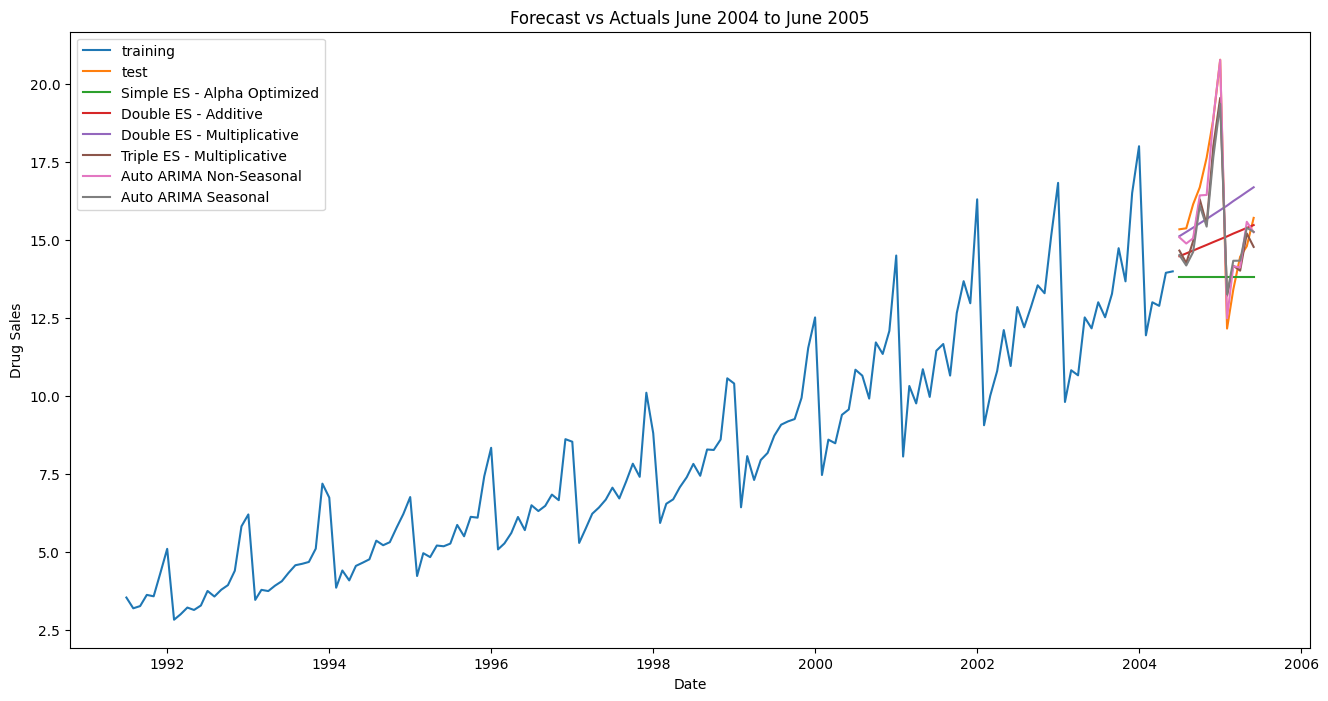

In [31]:
# Period 1
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_data_1, label='training')
plt.plot(test_data_1, label='test')
plt.plot(ins_cast1, label='Simple ES - Alpha Optimized')
plt.plot(double_ets_add_pred1, label='Double ES - Additive')
plt.plot(double_ets_mul_pred1, label='Double ES - Multiplicative')
plt.plot(triple_ets_add_pred1, label='Triple ES - Multiplicative')
plt.plot(triple_ets_mul_pred1, label='Auto ARIMA Non-Seasonal')
plt.plot(fc_auto_seasonal1, label='Auto ARIMA Seasonal')
plt.title('Forecast vs Actuals June 2004 to June 2005')
# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.legend()
plt.show()

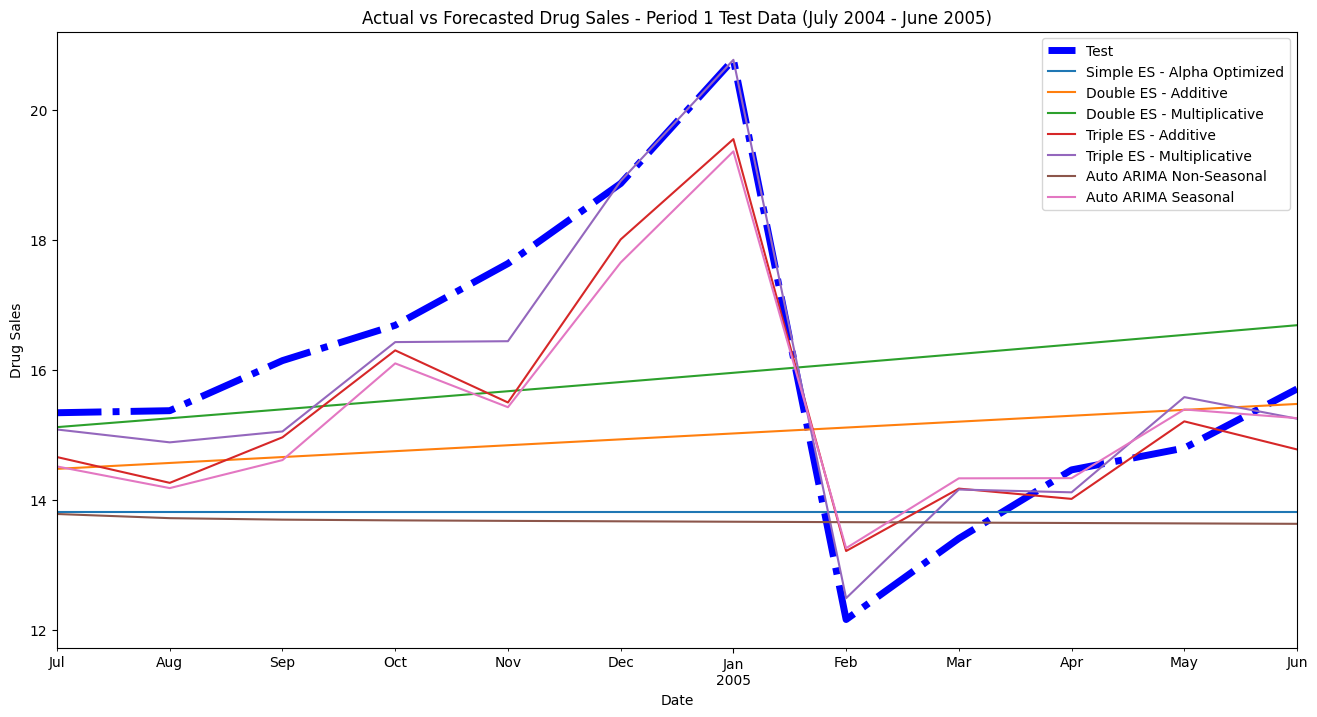

In [32]:
# Period 1

# Plot test data
plt.figure(figsize=(16, 8), dpi=100)
test_data_1['value'].plot(label='Test', linestyle='dashdot', linewidth=5, color='blue')

# Plot Period 1 results from each model
ins_cast1.plot(label='Simple ES - Alpha Optimized')
double_ets_add_pred1.plot(label='Double ES - Additive')
double_ets_mul_pred1.plot(label='Double ES - Multiplicative')
triple_ets_add_pred1.plot(label='Triple ES - Additive')
triple_ets_mul_pred1.plot(label='Triple ES - Multiplicative')
fc_series_auto_nonseasonal1.plot(label='Auto ARIMA Non-Seasonal')
fc_series_auto_seasonal1.plot(label='Auto ARIMA Seasonal')

# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')

# adding title to plot
plt.title('Actual vs Forecasted Drug Sales - Period 1 Test Data (July 2004 - June 2005)')

# adding legend to the curve
plt.legend()

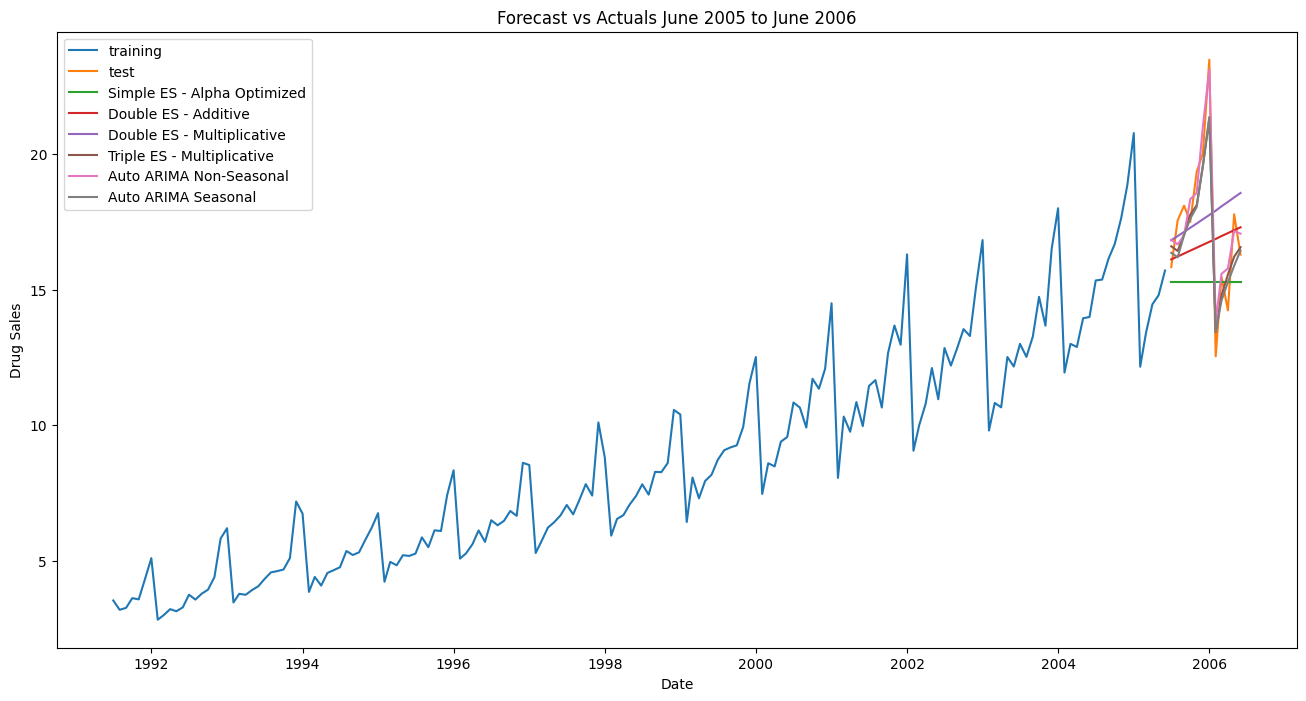

In [33]:
# Period 2
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_data_2, label='training')
plt.plot(test_data_2, label='test')
plt.plot(ins_cast2, label='Simple ES - Alpha Optimized')
plt.plot(double_ets_add_pred2, label='Double ES - Additive')
plt.plot(double_ets_mul_pred2, label='Double ES - Multiplicative')
plt.plot(triple_ets_add_pred2, label='Triple ES - Multiplicative')
plt.plot(triple_ets_mul_pred2, label='Auto ARIMA Non-Seasonal')
plt.plot(fc_auto_seasonal2, label='Auto ARIMA Seasonal')
plt.title('Forecast vs Actuals June 2005 to June 2006')
# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.legend()
plt.show()

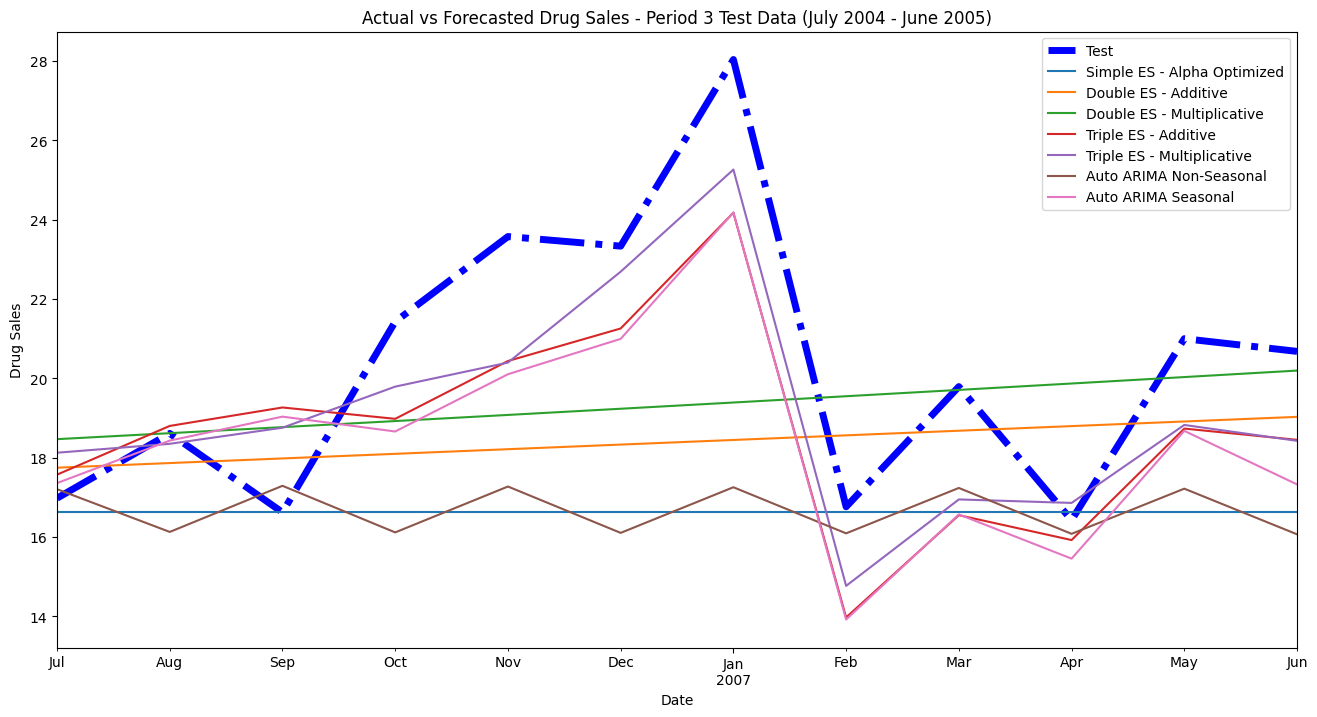

In [34]:
# Period 3

# Plot test data
plt.figure(figsize=(16, 8), dpi=100)
test_data_3['value'].plot(label='Test', linestyle='dashdot', linewidth=5, color='blue')

# Plot Period 3 results from each model
ins_cast3.plot(label='Simple ES - Alpha Optimized')
double_ets_add_pred3.plot(label='Double ES - Additive')
double_ets_mul_pred3.plot(label='Double ES - Multiplicative')
triple_ets_add_pred3.plot(label='Triple ES - Additive')
triple_ets_mul_pred3.plot(label='Triple ES - Multiplicative')
fc_series_auto_nonseasonal3.plot(label='Auto ARIMA Non-Seasonal')
fc_series_auto_seasonal3.plot(label='Auto ARIMA Seasonal')

# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')

# adding title to plot
plt.title('Actual vs Forecasted Drug Sales - Period 3 Test Data (July 2004 - June 2005)')

# adding legend to the curve
plt.legend()

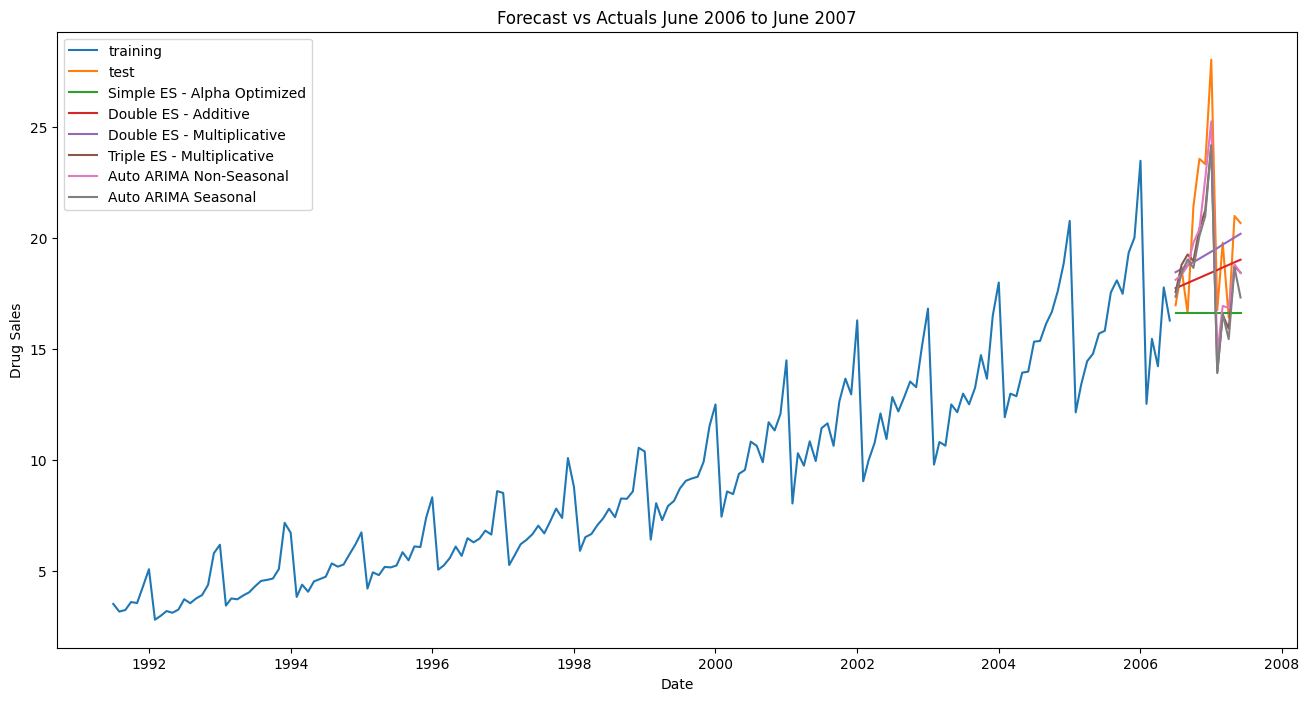

In [35]:
# Period 3
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_data_3, label='training')
plt.plot(test_data_3, label='test')
plt.plot(ins_cast3, label='Simple ES - Alpha Optimized')
plt.plot(double_ets_add_pred3, label='Double ES - Additive')
plt.plot(double_ets_mul_pred3, label='Double ES - Multiplicative')
plt.plot(triple_ets_add_pred3, label='Triple ES - Multiplicative')
plt.plot(triple_ets_mul_pred3, label='Auto ARIMA Non-Seasonal')
plt.plot(fc_auto_seasonal3, label='Auto ARIMA Seasonal')
plt.title('Forecast vs Actuals June 2006 to June 2007')
# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.legend()
plt.show()

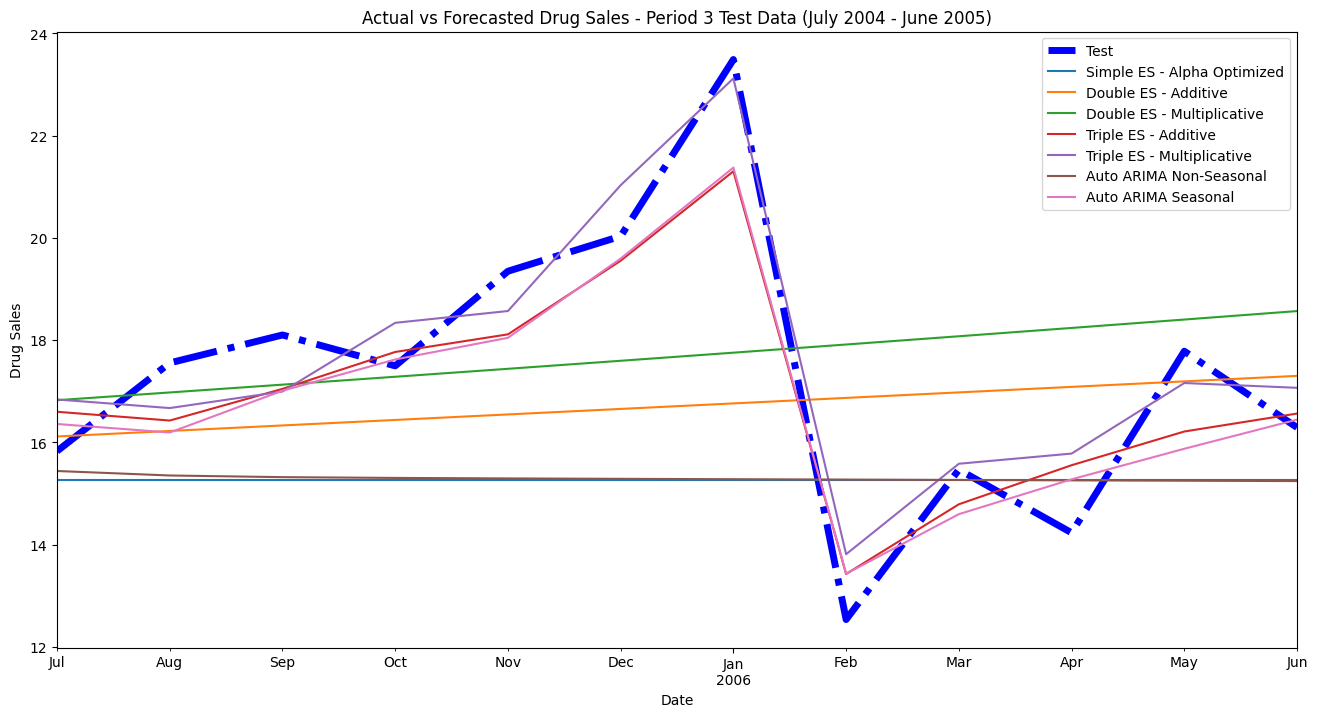

In [36]:
# Period 2

# Plot test data
plt.figure(figsize=(16, 8), dpi=100)
test_data_2['value'].plot(label='Test', linestyle='dashdot', linewidth=5, color='blue')

# Plot Period 2 results from each model
ins_cast2.plot(label='Simple ES - Alpha Optimized')
double_ets_add_pred2.plot(label='Double ES - Additive')
double_ets_mul_pred2.plot(label='Double ES - Multiplicative')
triple_ets_add_pred2.plot(label='Triple ES - Additive')
triple_ets_mul_pred2.plot(label='Triple ES - Multiplicative')
fc_series_auto_nonseasonal2.plot(label='Auto ARIMA Non-Seasonal')
fc_series_auto_seasonal2.plot(label='Auto ARIMA Seasonal')

# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')

# adding title to plot
plt.title('Actual vs Forecasted Drug Sales - Period 3 Test Data (July 2004 - June 2005)')

# adding legend to the curve
plt.legend()

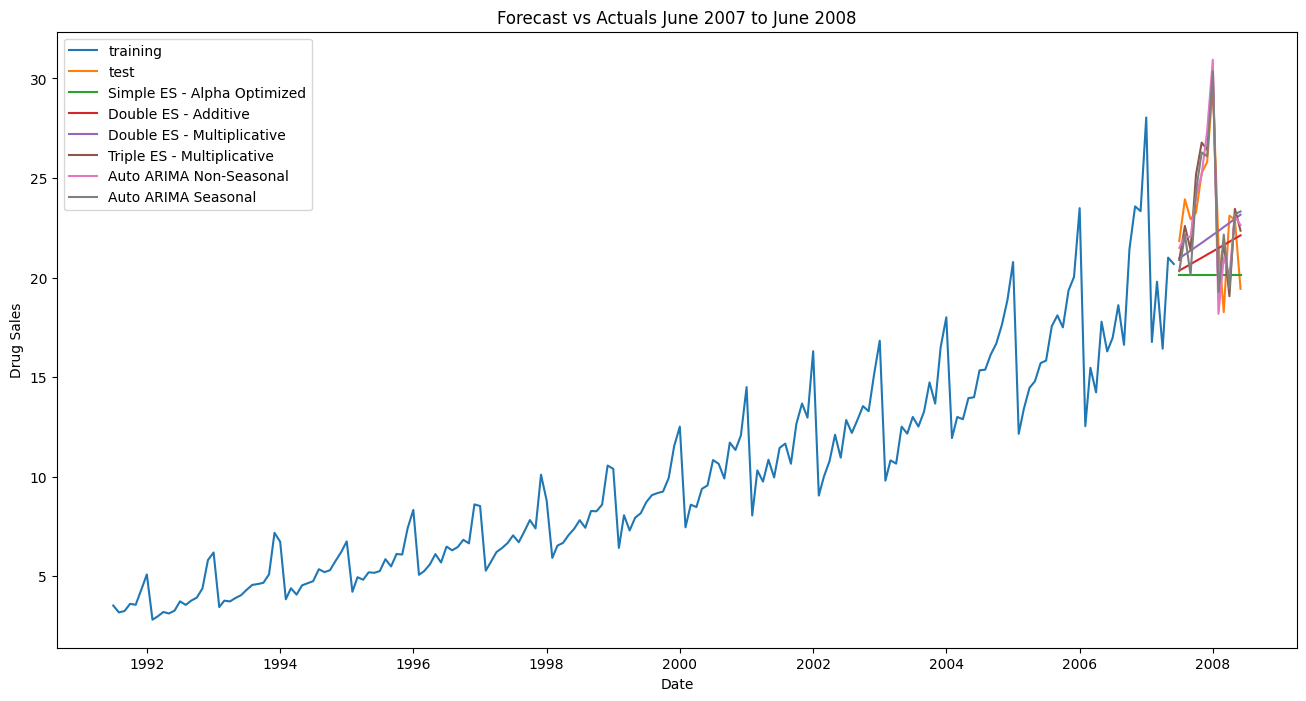

In [37]:
# Period 4
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_data_4, label='training')
plt.plot(test_data_4, label='test')
plt.plot(ins_cast4, label='Simple ES - Alpha Optimized')
plt.plot(double_ets_add_pred4, label='Double ES - Additive')
plt.plot(double_ets_mul_pred4, label='Double ES - Multiplicative')
plt.plot(triple_ets_add_pred4, label='Triple ES - Multiplicative')
plt.plot(triple_ets_mul_pred4, label='Auto ARIMA Non-Seasonal')
plt.plot(fc_auto_seasonal4, label='Auto ARIMA Seasonal')

plt.title('Forecast vs Actuals June 2007 to June 2008')
# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.legend()
plt.show()

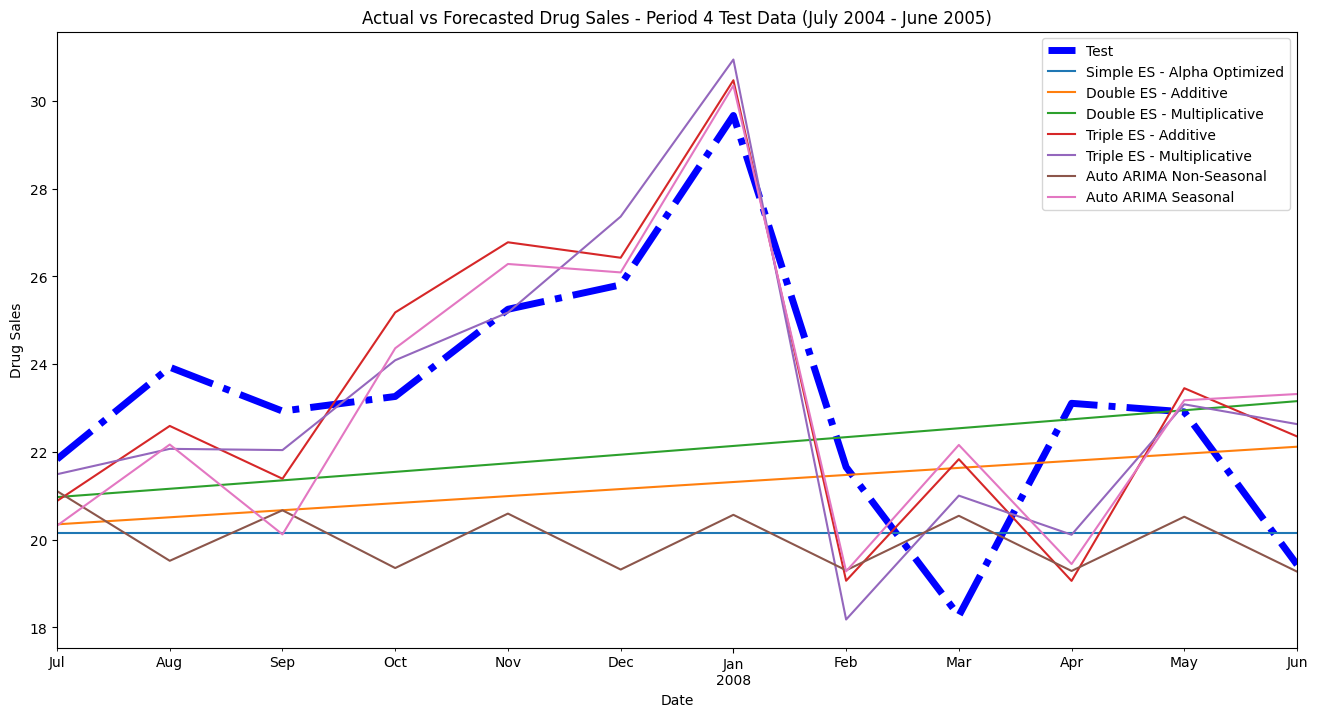

In [38]:
# Period 4

# Plot test data
plt.figure(figsize=(16, 8), dpi=100)
test_data_4['value'].plot(label='Test', linestyle='dashdot', linewidth=5, color='blue')

# Plot Period 1 results from each model
ins_cast4.plot(label='Simple ES - Alpha Optimized')
double_ets_add_pred4.plot(label='Double ES - Additive')
double_ets_mul_pred4.plot(label='Double ES - Multiplicative')
triple_ets_add_pred4.plot(label='Triple ES - Additive')
triple_ets_mul_pred4.plot(label='Triple ES - Multiplicative')
fc_series_auto_nonseasonal4.plot(label='Auto ARIMA Non-Seasonal')
fc_series_auto_seasonal4.plot(label='Auto ARIMA Seasonal')

# adding Label to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Drug Sales')

# adding title to plot
plt.title('Actual vs Forecasted Drug Sales - Period 4 Test Data (July 2004 - June 2005)')

# adding legend to the curve
plt.legend()

From above visualizatons, I observed the purple curve(forecasted) roughly fits the best with the blue dashdotted line (Test). Therefore, my observation is "triple exponential smoothing - multiplicative" would be the best option to predict the future sales.

## 5. Metrics

In [39]:
# Define metrics dataframe which will be used below for
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE', 'MSE'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae,
                       'MAPE': mape,
                       'MSE': mse}, index=[0])

    dataframe = metrics_dataframe.append(df)
    return dataframe

In [40]:
# Period 1 Metrics
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), ins_cast1.values.flatten(),
                                'Period 1 - Simple Alpha Optimized')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), double_ets_add_pred1.values.flatten(),
                                'Period 1 - Double Add')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), double_ets_mul_pred1.values.flatten(),
                                'Period 1 - Double Mul')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), triple_ets_add_pred1.values.flatten(),
                                'Period 1 - Triple Add')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), triple_ets_mul_pred1.values.flatten(),
                                'Period 1 - Triple Mul')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), fc_series_auto_nonseasonal1.values.flatten(),
                                'Period 1 - Non-Seasonal Auto ARIMA')
metrics_dataframe = metrics_cal(test_data_1.values.flatten(), fc_series_auto_seasonal1.values.flatten(),
                                'Period 1 - Seasonal Auto ARIMA')

# Period 2 Metrics
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), ins_cast2.values.flatten(),
                                'Period 2 - Simple Alpha Optimized')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), double_ets_add_pred2.values.flatten(),
                                'Period 2 - Double Add')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), double_ets_mul_pred2.values.flatten(),
                                'Period 2 - Double Mul')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), triple_ets_add_pred2.values.flatten(),
                                'Period 2 - Triple Add')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), triple_ets_mul_pred2.values.flatten(),
                                'Period 2 - Triple Mul')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), fc_series_auto_nonseasonal2.values.flatten(),
                                'Period 2 - Non-Seasonal Auto ARIMA')
metrics_dataframe = metrics_cal(test_data_2.values.flatten(), fc_series_auto_seasonal2.values.flatten(),
                                'Period 2 - Seasonal Auto ARIMA')

# Period 3 Metrics
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), ins_cast3.values.flatten(),
                                'Period 3 - Simple Alpha Optimized')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), double_ets_add_pred3.values.flatten(),
                                'Period 3 - Double Add')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), double_ets_mul_pred3.values.flatten(),
                                'Period 3 - Double Mul')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), triple_ets_add_pred3.values.flatten(),
                                'Period 3 - Triple Add')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), triple_ets_mul_pred3.values.flatten(),
                                'Period 3 - Triple Mul')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), fc_series_auto_nonseasonal3.values.flatten(),
                                'Period 3 - Non-Seasonal Auto ARIMA')
metrics_dataframe = metrics_cal(test_data_3.values.flatten(), fc_series_auto_seasonal3.values.flatten(),
                                'Period 3 - Seasonal Auto ARIMA')

# Period 4 Metrics
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), ins_cast4.values.flatten(),
                                'Period 4 - Simple Alpha Optimized')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), double_ets_add_pred4.values.flatten(),
                                'Period 4 - Double Add')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), double_ets_mul_pred4.values.flatten(),
                                'Period 4 - Double Mul')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), triple_ets_add_pred4.values.flatten(),
                                'Period 4 - Triple Add')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), triple_ets_mul_pred4.values.flatten(),
                                'Period 4 - Triple Mul')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), fc_series_auto_nonseasonal4.values.flatten(),
                                'Period 4 - Non-Seasonal Auto ARIMA')
metrics_dataframe = metrics_cal(test_data_4.values.flatten(), fc_series_auto_seasonal4.values.flatten(),
                                'Period 4 - Seasonal Auto ARIMA')


### Model Evaluation

In [41]:
metrics_dataframe = metrics_dataframe.drop_duplicates()
metrics = metrics_dataframe.sort_values(by='MAE')

## 6. Recommendations

Comparing the metrics from the above table, **Multiplicative Triple Exponential Smoothing** yields the lowest error with all the metric (RMSE, MAE, MAPE and MSE) so it would be the best model.